In [341]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [342]:
data = pd.read_csv("wafer_data.csv")

In [343]:
data.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,Class
0,100,160,1.6000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20,83,4.1500,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,99,150,1.5151,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40,40,1.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,234,19.5000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


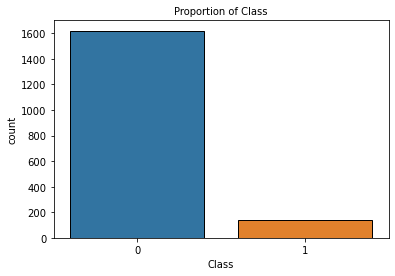

In [345]:
plt.title("Proportion of Class", size = 10)
sns.countplot(data['Class'], edgecolor = (0,0,0))
plt.show()

In [346]:
X = data.drop('Class', axis = 1) # 종속변수인 Class를 제외한 데이터를 독립변수로 지정
y = data.Class # Class 변수를 종속변수로 지정 

## Preprocessing

In [502]:
before = abs(X.skew()) # 독립변수들의 왜도 절댓값을 지정

In [348]:
X = X[before[before <= 4].index] # 왜도의 절댓값이 4이하인 변수들만 사용

## Modeling

In [349]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [350]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y) # 데이터를 학습용 80%, 검증용 20%로 분할하고 이 때 분류문제이므로 층화추출 인자 사용

### RandomForest

In [427]:
rf = RandomForestClassifier(random_state = 42)

In [391]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [392]:
rf_pred = rf.predict_proba(X_test)[:, 1]

In [395]:
rf_score = roc_auc_score(y_test, rf_pred)

In [396]:
print(f'{rf.__class__.__name__}의 roc_auc = {round(rf_score, 4)}')

RandomForestClassifier의 roc_auc = 0.903


### LightGBM

In [370]:
lgbm = LGBMClassifier(random_state = 42)

In [371]:
lgbm.fit(X_train, y_train)

LGBMClassifier(random_state=42)

In [372]:
lgbm_pred = lgbm.predict_proba(X_test)[:, 1]

In [387]:
lgbm_score = roc_auc_score(y_test, lgbm_pred)

In [388]:
print(f'{lgbm.__class__.__name__}의 roc_auc = {round(lgbm_score, 4)}')

LGBMClassifier의 roc_auc = 0.8976


### XGBoost

In [438]:
xgb = XGBClassifier(random_state = 42, eval_metric = 'logloss')

In [439]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [440]:
xgb_pred = xgb.predict_proba(X_test)[:, 1]

In [441]:
xgb_score = roc_auc_score(y_test, xgb_pred)

In [442]:
print(f'{xgb.__class__.__name__}의 roc_auc = {round(xgb_score, 4)}')

XGBClassifier의 roc_auc = 0.8927


### CatBoost

In [397]:
cb = CatBoostClassifier(random_state = 42, verbose = 0)

In [398]:
cb.fit(X_train, y_train)

In [399]:
cb_pred = cb.predict_proba(X_test)[:, 1]

In [400]:
cb_score = roc_auc_score(y_test, cb_pred)

In [401]:
print(f'{cb.__class__.__name__}의 roc_auc = {round(cb_score, 4)}')

CatBoostClassifier의 roc_auc = 0.9058


***
## Hyper Parameter Tuning

In [505]:
skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = False) # 층화추출기법 기반 KFold로 학습 및 검증용 데이터의 종속변수 클래스별 분포가 같도록 한다.

In [428]:
def tuning_prediction(params, model) :
    model_cv = GridSearchCV(model, params, cv = skf, scoring = 'roc_auc') # roc_auc 지표를 기준으로 5-fold 검증 수행
    result = model_cv.fit(X_train, y_train)
    model = result.best_estimator_ # 최적의 파라미터로 세팅된 모델
    model.fit(X_train, y_train)
    pred = model.predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_test, pred)
    print(f'{model.__class__.__name__}의 최적의 파라미터 조합은{result.best_params_}')
    print(f'{model.__class__.__name__}의 roc_auc = {round(score, 4)}')

### RandomForest Tuning

In [409]:
rf_params = {'max_depth' : [3, 4, 5, 6, 7], 'n_estimators' : [50, 100, 150, 200, 250, 300, 500]}

In [429]:
tuning_prediction(rf_params, rf)

RandomForestClassifier의 최적의 파라미터 조합은{'max_depth': 7, 'n_estimators': 250}
RandomForestClassifier의 roc_auc = 0.8968


### LightGBM Tuning

In [430]:
lgbm_params = {'learning_rate' : [0.01, 0.03, 0.05, 0.1, 0.15, 0.2], 'max_depth' : [3, 4, 5, 6, 7],
              'n_estimators' : [50, 100, 200, 250, 300, 500, 1000]}

In [431]:
tuning_prediction(lgbm_params, lgbm)

LGBMClassifier의 최적의 파라미터 조합은{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 50}
LGBMClassifier의 roc_auc = 0.9092


### XGBoost Tuning

In [443]:
xgb_params = {'learning_rate' : [0.01, 0.03, 0.05, 0.1, 0.15, 0.2], 'max_depth' : [3, 4, 5, 6, 7],
              'n_estimators' : [50, 100, 200, 250, 300, 500, 1000]}

In [444]:
tuning_prediction(xgb_params, xgb)

XGBClassifier의 최적의 파라미터 조합은{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 1000}
XGBClassifier의 roc_auc = 0.8795


### CatBoost Tuning

In [445]:
cb_params = {'learning_rate' : [0.01, 0.03, 0.05, 0.1, 0.15, 0.2], 'max_depth' : [3, 4, 5, 6, 7],
              'iterations' : [50, 100, 200, 250, 300, 500, 1000]}

In [446]:
tuning_prediction(cb_params, cb)

CatBoostClassifier의 최적의 파라미터 조합은{'iterations': 500, 'learning_rate': 0.03, 'max_depth': 6}
CatBoostClassifier의 roc_auc = 0.8999


***
## Ensemble

In [451]:
cb = CatBoostClassifier(random_state = 42, verbose = 0)

In [452]:
cb.fit(X_train, y_train)

In [453]:
cb_pred = cb.predict_proba(X_test)[:, 1]

In [454]:
rf = RandomForestClassifier(random_state = 42)

In [455]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [456]:
rf_pred = rf.predict_proba(X_test)[:, 1]

In [457]:
lgbm = LGBMClassifier(random_state = 42, **{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 50})

In [458]:
lgbm.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.05, max_depth=5, n_estimators=50,
               random_state=42)

In [459]:
lgbm_pred = lgbm.predict_proba(X_test)[:, 1]

In [482]:
xgb = XGBClassifier(random_state = 42, eval_metric = 'logloss')

In [483]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [484]:
xgb_pred = xgb.predict_proba(X_test)[:, 1]

In [497]:
final_pred = (lgbm_pred * 0.4 + cb_pred * 0.25 + rf_pred * 0.35) # lightgbm, CatBoost, RandomForest의 예측값을 앙상블을 통해 성능을 높인다.

In [498]:
roc_auc_score(y_test, final_pred)

0.9113452532992764